# Table of Contents

* [1 General Functions](#general_functions)
    * [1.1 Functions to Save and Open Variables](#open_save)
* [2 Datasets](#load_datasets)
    * [2.1 Load Reuters Corpus Volume 1 (rcv1) Dataset](#load_rcv1)
    * [2.2 Dataset Attributes of rcv1](#attributes_rcv1)
    * [2.3 Load Modified National Institute of Standards and Technology (MNIST) Dataset](#load_mnist)
    * [2.4 Train/Test Split](#train_test_split)
    * [2.5 Dataset Attributes of MNIST](#attributes_mnist)
* [3 Document Classification](#document_classification)
    * [3.1 Naive Bayes](#naive_bayes)
        * [3.1.1 Naive Bayes on rcv1](#nb_rcv1)
        * [3.1.2 Naive Bayes on MNIST](#nb_mnist)
    * [3.2 Generating Predictions](#generating_predictions)
    * [3.3 Evaluating Predictions](#evaluating_predictions)
    * [3.4 Recall vs Precision Graph](#recall_precision_graph)
        * [3.4.1 Recall-Precision Graph for Naive Bayes with rcv1](#graph_nb_rcv1)
        * [3.4.2 Recall-Precision Graph for for Naive Bayes with MNIST](#graph_nb_mnist)
    * [3.5 K-Folds Cross-Validation](#k_folds)
    * [3.6 Support Vector Machines (SVM)](#svm)
        * [3.6.1 SVM on rcv1](#svm_rcv1)
        * [3.6.2 SVM on mnist](#svm_mnist)
    * [3.7 k-Nearest Neighbors (kNN)](#knn)
        * [3.7.1 kNN on rcv1](#knn_rcv1)
        * [3.7.2 kNN on mnist](#knn_mnist)
    * [3.8 Decision Trees](#decision_trees)
        * [3.7.1 Decision Trees on rcv1](#dt_rcv1)
        * [3.7.2 Decision Trees on mnist](#dt_mnist)    

# General Functions <a id='general_functions'></a>

## Functions to Save and Open Variables <a id='open_save'></a>

Since it is not uncommon for a machine learning task to take a long time it is good practice to save variables that may be needed in the future. This can be achieved by using the [pickle](https://docs.python.org/3/library/pickle.html) module. This package allows a variable up to 4gb to be saved. This limitation is why the 'metrics' variables are saved as individual items instead of a dictionary.

In [1]:
# Save variables to file
import pickle

def save_var(variable_name):
    """ Saves the variable with the provided variable name 
         in the global namespace to the ./vars folder 
         with the provided same name """
    
    with open('./vars/' + variable_name,'wb') as my_file_obj:
        pickle.dump(globals()[variable_name], my_file_obj, protocol=4)

def save_var_list(variable_name_list):
    """ Saves each variable with the provided variable name 
         in the global namespace to the ./vars folder 
         with the provided same name """
    for name in variable_name_list:
        with open('./vars/' + name,'wb') as my_file_obj:
            pickle.dump(globals()[name], my_file_obj, protocol=pickle.HIGHEST_PROTOCOL)

def open_var(file_name):
    """ Returns the variable saved with the provided 
         file name located in the ./vars folder"""
    
    file_object = open('./vars/' + file_name,'rb')  

    loaded_var = pickle.load(file_object)
    
    return loaded_var

def open_var_list(file_name_list):
    """ Loads a variable corresponding to each file name
         in file_name_list to the global namespace. """
    
    for file_name in file_name_list:
        globals()[file_name] = open_var(file_name)

In [2]:
%time open_var_list(['rcv1_train', 'rcv1_test'])

CPU times: user 644 ms, sys: 2.15 s, total: 2.79 s
Wall time: 1.03 s


In [ ]:
%time save_var_list(['mnist', 'mnist_train', 'mnist_test', 'rcv1_train', 'rcv1_test'])

In [2]:
class Dataset_Part:
    """ Represents a dataset with attributes
         data and target """
    
    data = None
    target = None
    def __init__(self, X, y):
        self.data = X
        self.target = y

%time open_var_list(['mnist_train', 'mnist_test'])

CPU times: user 360 ms, sys: 1.76 s, total: 2.12 s
Wall time: 131 ms


## Load Datasets <a id='load_datasets'></a>

### [Load Reuters Corpus Volume I (rcv1) Dataset](http://scikit-learn.org/stable/datasets/rcv1.html) <a id='load_rcv1'></a>

Scikit-learn includes functions to easily load some popular datasets. One of the included datasets is rcv1. This dataset can be loaded completly or broken into test and train subsets. This dataset consists of over 800,000 manually categorized news stories. The data is represented by cosine-normalized log TF-IDF vectors and the labels are 103 classes with binary values.

In [13]:
from sklearn.datasets import fetch_rcv1

%time rcv1 = fetch_rcv1()

CPU times: user 12.3 s, sys: 420 ms, total: 12.7 s
Wall time: 12.7 s


In [14]:
from sklearn.datasets import fetch_rcv1

%time rcv1_train, rcv1_test = (fetch_rcv1(subset='train'), fetch_rcv1(subset='test'))

CPU times: user 24.8 s, sys: 1.47 s, total: 26.2 s
Wall time: 26.2 s


### Dataset Attributes of rcv1 <a id='attributes_rcv1'></a>

Datasets loaded from scikit-learn will typically have several attributes.

   1. __data__ - a scipy [compressed row storage (CSR) sparce matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html). Non-zero values are cosinne-normalized, log TF-IDF vectors. The shape is (num_samples, num_features)
   2. __target__ - a scipy CSR sparse matrix. Maps each sample to relavent categories (sometimes refered to as labels). The shape is (num_samples, num_categories).
   3. __sample_id__ - a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) (ndarray) associating each sample's ID to its sample number
   4. __target_names__ - a ndarray of target names (can be thought of as topics or categories) corresponding to the category mapping in __(2)__. Each sample belongs to n categories, where 1 $\le$ n $\le$ 13.
   5. __DESCR__ - a description of the dataset
   
The shape attribute gives the dimensions of the matrix.

In [4]:
def get_nonzero(matrix):
    """ Returns the percent of items in the provided 
         matrix that are not 0.
         
        Params:
          matrix -- a csr sparse matrix """
    
    nonzero = (matrix.count_nonzero() / (matrix.shape[0] * matrix.shape[1])) * 100
    # Check value is valid
    assert nonzero <= 100
    assert nonzero >= 0
    
    return nonzero

def print_rcv1_attributes(dataset):
    """ Prints attributes of the provided dataset.
    
        Params:
          dataset -- the RCV1 full dataset or a subset """
    
    print(f'  rcv1 type: {type(dataset)}')
    
    print ('data:')
    print(f'      shape: {dataset.data.shape}')
    print(f'  data type: {dataset.data.dtype}')
    print(f' array type: {type(dataset.data)}')
    print(f'    nonzero: {get_nonzero(dataset.data):0.4f}%\n')

    print('target:')
    print(f'      shape: {dataset.target.shape}')
    print(f'  data type: {dataset.target.dtype}')
    print(f' array type: {type(dataset.target)}')
    print(f'    nonzero: {get_nonzero(dataset.target):0.4f}%\n')

    print('sample_id:')
    print(f'      shape: {dataset.sample_id.shape}')
    print(f'  data type: {type(dataset.sample_id[3])}')
    print(f' array type: {type(dataset.sample_id)}\n')

    print('target_names:')
    print(f'      shape: {dataset.target_names.shape}')
    print(f'  data type: {type(dataset.target_names[3])}')
    print(f' array type: {type(dataset.target_names)}')

In [16]:
print('rcv1 dataset attributes')
print_rcv1_attributes(rcv1)

rcv1 dataset attributes
  rcv1 type: <class 'sklearn.utils.Bunch'>
data:
      shape: (804414, 47236)
  data type: float64
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 0.1603%

target:
      shape: (804414, 103)
  data type: uint8
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 3.1463%

sample_id:
      shape: (804414,)
  data type: <class 'numpy.uint32'>
 array type: <class 'numpy.ndarray'>

target_names:
      shape: (103,)
  data type: <class 'str'>
 array type: <class 'numpy.ndarray'>


In [5]:
print('rcv1 training subset attributes:')
print_rcv1_attributes(rcv1_train)

rcv1 training subset attributes:
  rcv1 type: <class 'sklearn.utils.Bunch'>
data:
      shape: (23149, 47236)
  data type: float64
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 0.1608%

target:
      shape: (23149, 103)
  data type: uint8
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 3.0909%

sample_id:
      shape: (23149,)
  data type: <class 'numpy.uint32'>
 array type: <class 'numpy.ndarray'>

target_names:
      shape: (103,)
  data type: <class 'str'>
 array type: <class 'numpy.ndarray'>


In [6]:
print('\nrcv1 testing subset attributes:')
print_rcv1_attributes(rcv1_test)


rcv1 testing subset attributes:
  rcv1 type: <class 'sklearn.utils.Bunch'>
data:
      shape: (781265, 47236)
  data type: float64
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 0.1603%

target:
      shape: (781265, 103)
  data type: uint8
 array type: <class 'scipy.sparse.csr.csr_matrix'>
    nonzero: 3.1480%

sample_id:
      shape: (781265,)
  data type: <class 'numpy.uint32'>
 array type: <class 'numpy.ndarray'>

target_names:
      shape: (103,)
  data type: <class 'str'>
 array type: <class 'numpy.ndarray'>


### [Modified National Institute of Standards and Technology (MNIST) Dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_mldata.html) <a id='load_mnist'></a>

Another included dataset is MNIST. This dataset is 70,000 handwritten digits represented by 28x28 pixel images. The classes correspond to the number shown in the image. Since each image is 28x28 each pixel is a feature giving each document 784 features.

In [ ]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

### Train/Test Split <a id='train_test_split'></a>

Since MNIST does not have a default train/test set like rcv1 we will use a train/test split. This is when a dataset is broken into two parts, one to train the classifier and one to test it. When decomposing the dataset it is important to ensure equal representation of each class. MNIST is sorted by  digit; therefore, if the dataset is simply partitioned in order there may be no instances of a particular class. This can be alleviated by shuffling the dataset. 

In [ ]:
from sklearn.model_selection import train_test_split

# To keep the .data and .target format consistent 
class Dataset_Part:
    """ Represents a dataset with attributes
         data and target """
    
    data = None
    target = None
    def __init__(self, X, y):
        self.data = X
        self.target = y

X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=.33, random_state=35)
mnist_train, mnist_test = Dataset_Part(X_train, y_train), Dataset_Part(X_test, y_test)

### Dataset Attributes of MNIST <a id='attributes_mnist'></a>

Datasets loaded from scikit-learn will typically have several attributes.

   1. __data__ - a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) (ndarray). The value of each feature corresponds to the intensity of a pixel. Each feature is represented by an intensity 0 (white) to 255 (black). The shape is (num_samples, num_features).
   2. __target__ - a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) (ndarray) associating each sample's ID to the value of the handwritten digit.
   
The shape attribute gives the dimensions of the matrix.

In [4]:
import numpy as np

def get_avg_nonzero(subset):
    """ Returns the percent of items in the provided 
         list matricies that are not 0.
         
        Params:
          matrix -- a csr sparse matrix """
    
    return (np.count_nonzero(subset) / (subset.shape[1] * subset.shape[0])) * 100

def print_mnist_attributes(dataset):
    """ Prints attributes of the provided dataset.
    
        Params:
          dataset -- the mnist full dataset """
    
    print(f'     mnist type: {type(dataset)}')
    
    print ('data:')
    print(f'          shape: {dataset.data.shape}')
    print(f'      data type: {dataset.data.dtype}')
    print(f'     array type: {type(dataset.data)}')
    print(f' nonzero pixels: {get_avg_nonzero(dataset.data):0.4f}%\n')

    print('target:')
    print(f'          shape: {dataset.target.shape}')
    print(f'      data type: {dataset.target.dtype}')
    print(f'     array type: {type(dataset.target)}')

In [7]:
print('MNIST train dataset attributes')
print_mnist_attributes(mnist_train)

MNIST train dataset attributes
     mnist type: <class '__main__.Dataset_Part'>
data:
          shape: (46900, 784)
      data type: uint8
     array type: <class 'numpy.ndarray'>
 nonzero pixels: 19.1391%

target:
          shape: (46900,)
      data type: float64
     array type: <class 'numpy.ndarray'>


In [8]:
print('MNIST test dataset attributes')
print_mnist_attributes(mnist_test)

MNIST test dataset attributes
     mnist type: <class '__main__.Dataset_Part'>
data:
          shape: (23100, 784)
      data type: uint8
     array type: <class 'numpy.ndarray'>
 nonzero pixels: 19.1492%

target:
          shape: (23100,)
      data type: float64
     array type: <class 'numpy.ndarray'>


It is also possible to view a document as an image by reshaping the array to a 28x28 matrix.

	Index: 30861	Label: 7


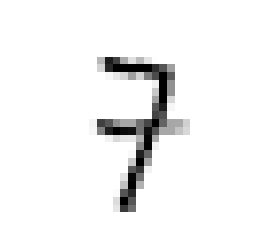

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import random

def print_rand_digit():  
    # Get a random document
    rand_index = random.randint(0,70000)
    rand_digit = mnist_train.data[rand_index]
    # Reshape it to the size of the image
    rand_digit_image = rand_digit.reshape(28,28)

    # Some information
    print(f'\tIndex: {rand_index}\tLabel: {mnist_train.target[rand_index]:.0f}')
    # Show the image
    plt.imshow(rand_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
    
print_rand_digit()

## Document Classification <a id='document_classification'></a>

## [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) <a id='naive_bayes'></a>
A supervised learning algorithm based on using Bayes' theorem. This method assumes independence between each pair of features.

Bayes Theorem from eq. 1 in [zhang-2004]:
\begin{equation}
p(c \mid x_1, . . ., x_n) = \frac{P(c) P(a_1, . . ., a_n | y)} {P(a_1, . . ., a_n)}
\end{equation}

By assuming all attributes are independent we can further simplify $p(a_1, . . ., a_n \mid c)$ eq. 2 from [zhang-2008], this is the naive assumption of naive bayes.

\begin{equation}
p(x_1, . . ., x_n \mid c) = \prod_{i = 1}^{n} P(x_i | c)
\end{equation}

This gives us our classification rule, as shown in eq. 3 from [zhang-2008]. 

\begin{equation}
C_{nb}(x_1, . . ., x_n) = \underset{c}{arg} \max p(c)  \prod_{i = 1}^{n} P(x_i | c)
\end{equation}

SciKit Learn supports several Naive Bayes implimentations. 
1. [__Gaussian Naive Bayes__](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) - In this implementation the likelihood of the features is assumed to be Gaussian. Gussian distributions are more commonly reffered to as the normal distribution and in this instance will be represented as $g(x_i, \mu_{i,c}, \sigma_{i,c})$, where $\mu$ is the mean and $\sigma$ is the typical deviation. The probability of a document vector $\vec{x}$ using multinomial Naive Bayes is shown in section 2.2 of [metsis-2006]. Let $\vec{x}$ represent the term frequency vector of the document to be evaulated, where $x_i$ represents the number of times $t_i$ appears in the document.

\begin{equation}
    p(\vec{x} \mid c) =  \prod_{i = 1}^{m} g(x_i, \mu_{i,c}, \sigma_{i,c})
\end{equation}

2. [__Multinomial Naive Bayes__](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) - In this implementation the likelihood of the features is assumed to follow a multinomial distribution. Typically used in text classification. This model is useful in text calssification because it uses word frequency in classification decisions [mccallum-1998]. The probability of a document vector $\vec{x}$ using multinomial Naive Bayes is shown in section 2.2 of [metsis-2006]. Let $\vec{x}$ represent the term frequency vector of the document to be evaulated, where $x_i$ represents the number of times $t_i$ appears in document $d$, and let $d$ be a bag of words representation of the document.

\begin{equation}
    p(\vec{x} \mid c) =  p(\mid d \mid) \cdot \mid d \mid ! \cdot  \prod_{i = 1}^{m} \frac{p(t_i \mid c)^{x_i} }{x_i!}
\end{equation}

3. [__Bernoulli Naive Bayes__](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) - This implimentaiton assumes the data follows multivariate Bernoulli distributions. Multiple features are allowed but each feature is assumed to be a binary variable [mccallum-1998]. The probability of a binary document vector $\vec{x}$ using multivatiate Bernoulli Naive Bayes is shown in section 2.1 of [metsis-2006]. Let $\vec{x}$ be a binary vector where $x_i$ represents whether term $t_i$ is in the document.

\begin{equation}
    p(\vec{x} \mid c) =  \prod_{i = 1}^{m} p(t_i \mid c)^{x_i} \cdot (1 - p(t_i \mid c)^{(1 - x_i)}
\end{equation}

</a> Because of these restrictions only Multinomial Naive Bayes will be appropriate for the RCV1 dataset. There is an additional step required because Naive Bayes does not typically predict multilple labels. This means an additional strategy must be implemented. One commonly used startegy is known as one-vs-all ([one-vs-the-rest](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier) in scikit learn). This strategy works by using one classifier for each label.

## Naive Bayes on rcv1 <a id='nb_rcv1'>

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

clf_NB = [OneVsRestClassifier(MultinomialNB(alpha=1), n_jobs=-1),
          OneVsRestClassifier(MultinomialNB(alpha=.25), n_jobs=-1),
          OneVsRestClassifier(MultinomialNB(alpha=.05), n_jobs=-1),
          OneVsRestClassifier(MultinomialNB(alpha=.01), n_jobs=-1)]
    
# rcv1 training set does not contain all the labels and throws a warning.
# This with statement will suppress these warnings.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    %time clf_NB = [clf.fit(rcv1_train.data, rcv1_train.target) for clf in clf_NB]

titles_NB = ['alpha=1', 'alpha=.25', 'alpha=.05', 'alpha=.01']

CPU times: user 16.1 s, sys: 3.27 s, total: 19.4 s
Wall time: 19 s


### Naive Bayes on MNIST<a id='nb_mnist'></a> 
Since MNIST is much smaller and not a multioutput problem it will be used to demenstrate Multinomial Niave Bayes, Gaussian Niave Bayes, and Bernoulli Niave Bayes. Notice that the OneVsRestClassifier is not necessary when using MNIST because it is not a multioutput dataset (meaning each sample only has one label).

In [12]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

clf_NB = [MultinomialNB(),
          GaussianNB(),
          BernoulliNB()]

%time clf_NB = [clf.fit(mnist_train.data, mnist_train.target) for clf in clf_NB]

titles_NB = ['Multinomial', 'Gaussian', 'Bernoulli']

CPU times: user 1 s, sys: 312 ms, total: 1.31 s
Wall time: 1.31 s


## Generating Predictions <a id='generating_predictions'></a>

Classifiers in machine learning are used to predict the label(s) of a new document that the classifier has never seen. Niave Bayes generates predictions by finding the label(s) with the highest probability.

In [6]:
%time pred_NB = [clf.predict(rcv1_test.data) for clf in clf_NB]

CPU times: user 2min 57s, sys: 4.66 s, total: 3min 1s
Wall time: 3min 1s


In [13]:
%time pred_NB = [clf.predict(mnist_test.data) for clf in clf_NB]

CPU times: user 1.35 s, sys: 1.02 s, total: 2.37 s
Wall time: 2.37 s


## Evaluating Predictions <a id='evaluating_predictions'></a>
When testing a machine learning algorithm it is difficult to determine how a classifier performs by looking at predictions, so several metrics are commonly used to evaluate their performance.

1. __accuracy__ - The percentage of labels predicted correctly.
+ __precision__ - The ratio of true positives to true positives and false positives.
+ __recall__ - The ratio of true positives to true positives and false negatives.
+ __average precision__ - The weighted mean of the precision achieved at eaach recall threshold.

The term 'micro' average refers to calculating the average of each label weighted with respect to how frequently they occur. This is most appropriate for the RCV1 dataset because the labels do not occur with the same frequency. Information on additional averaging methods can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score). 

The term 'macro' average refers to calculating the average of each label without taking the label frequency into account. This is appropriate for MNIST because each label occurs with the same frequency. 

In [4]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from numpy import arange, matrix

def get_scores(target, prediction, avg_type):
 
    scores = { 'accuracy': accuracy_score(target, prediction),
               'f1' : f1_score(target, prediction, average=avg_type),
               'recall' : recall_score(target, prediction, average=avg_type),
               'precision' : precision_score(target, prediction, average=avg_type) }
    
    return scores

def graph_scores(scores, keys, title):

    count = len(scores)
    metric = tuple(t.title() for t in scores[0].keys())
    colors=['b', 'g', 'r', 'c', 'm', 'y']
    bar_width = .81 / count
    y_vals = arange(len(metric))
    
    for i, score in enumerate(scores):
        plt.bar(y_vals + bar_width * (i + ((3 - count) / 2)) , tuple(score.values()), width=bar_width, align='center', alpha=0.2, color=colors[i], linewidth=1, edgecolor='k')

    plt.legend(keys, bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
    plt.xticks(y_vals + bar_width, metric)
    plt.ylabel('Score')
    plt.ylim(0.,1.)
    plt.title(f'Evaluation Metrics for {title}\n\n')

    plt.show()
    
def print_scores(scores, avg_type):
    print(f'Accuracy: {scores["accuracy"]:0.4f}')
    print(f'{avg_type}-averaged F1: {scores["f1"]:0.4f}')
    print(f'{avg_type} averaged recall: {scores["recall"]:0.4f}')
    print(f'{avg_type} averaged precision: {scores["precision"]:0.4f}')

### Scores for Naive Bayes on RCV1

In [6]:
scores_NB = [get_scores(rcv1_test.target, pred, 'micro') for pred in pred_NB]

for title, score in zip(titles_NB, scores_NB):
    print(f'\n{title}')
    print_scores(score, 'micro')


alpha=1
Accuracy: 0.0963
micro-averaged F1: 0.4922
micro averaged recall: 0.3308
micro averaged precision: 0.9615

alpha=.25
Accuracy: 0.2532
micro-averaged F1: 0.6223
micro averaged recall: 0.4758
micro averaged precision: 0.8993

alpha=.05
Accuracy: 0.3448
micro-averaged F1: 0.6948
micro averaged recall: 0.5934
micro averaged precision: 0.8381

alpha=.01
Accuracy: 0.3415
micro-averaged F1: 0.7040
micro averaged recall: 0.6175
micro averaged precision: 0.8187


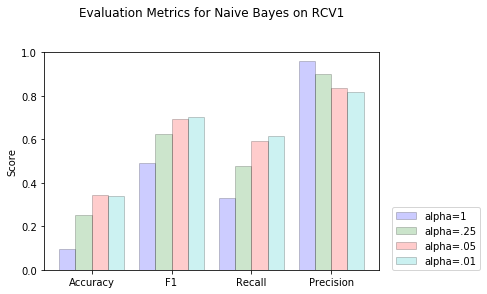

In [7]:
graph_scores(scores_NB, titles_NB, 'Naive Bayes on RCV1')

### Scores for Naive Bayes on MNIST

In [23]:
scores_NB = [get_scores(mnist_test.target, pred, 'macro') for pred in pred_NB]

for title, score in zip(titles_NB, scores_NB):
    print(f'\n{title} NB')
    print_scores(score, 'macro')


Multinomial NB
Accuracy: 0.8294
macro-averaged F1: 0.8281
macro averaged recall: 0.8263
macro averaged precision: 0.8360

Gaussian NB
Accuracy: 0.5543
macro-averaged F1: 0.5011
macro averaged recall: 0.5451
macro averaged precision: 0.6662

Bernoulli NB
Accuracy: 0.8363
macro-averaged F1: 0.8341
macro averaged recall: 0.8334
macro averaged precision: 0.8369


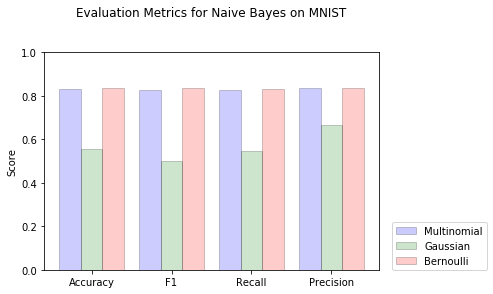

In [16]:
graph_scores(scores_NB, titles_NB, 'Naive Bayes on MNIST')

## Recall vs Precision Graph <a id='recall_precision_graph'></a>

Recall and precision are inversely related, as you increase one the other decreases. Because of this it is often nessicary to adjust the implementation to get the ideal precision or recall for the specific task at hand. A good way to visualize this tradeoff is by graphing recall vs precision at different prediction thresholds. 

In [3]:
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

from scipy.sparse import issparse
import matplotlib.pyplot as plt
import numpy as np

def graph_precision_recall(target, conf_list, titles, classes=[]):
    colors = iter(['b','r','g','c','m','k'])

    plt.figure()
    
    for confidence in conf_list:
        if issparse(target):
            target = target.toarray()
        
        # If target is multiclass it must be binarized
        if not np.array_equal(target, target.astype(bool)):
            classes_auto = np.unique(target)
            target = label_binarize(target, classes_auto if len(classes) < len(classes_auto) else classes)

        # A "micro-average": quantifying score on all classes jointly
        precision, recall, threshold = precision_recall_curve(target.ravel(), confidence.ravel())
        average_precision = average_precision_score(target, confidence, average="micro")

        
        plt.step(recall, precision, color=next(colors), alpha=.5,where='post')

    plt.legend(titles, bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curves')
    plt.show()

### Precision Recall Curve for Naive Bayes on RCV1 <a id='graph_nb_rcv1'></a>

CPU times: user 2min 56s, sys: 2.51 s, total: 2min 58s
Wall time: 2min 58s


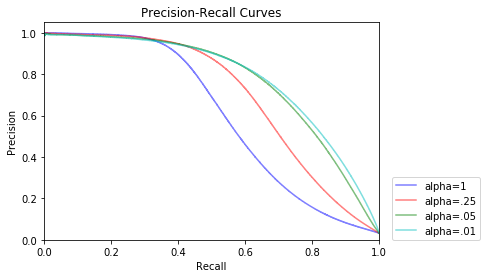

CPU times: user 5min 11s, sys: 39.8 s, total: 5min 51s
Wall time: 5min 50s


In [7]:
%time confidence_NB = [clf.predict_proba(rcv1_test.data) for clf in clf_NB]
%time graph_precision_recall(rcv1_test.target, confidence_NB, titles_NB) 

### Precision Recall Curve for Naive Bayes on MNIST <a id='graph_nb_mnist'></a>

CPU times: user 1.44 s, sys: 956 ms, total: 2.4 s
Wall time: 2.4 s


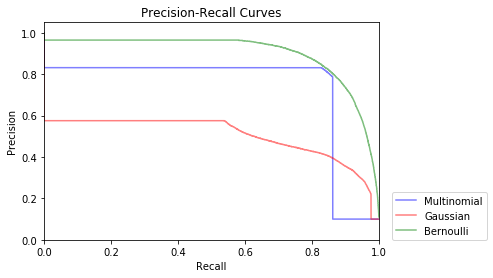

CPU times: user 652 ms, sys: 504 ms, total: 1.16 s
Wall time: 541 ms


In [64]:
%time confidence_NB = [clf.predict_proba(mnist_test.data) for clf in clf_NB]
%time graph_precision_recall(mnist_test.target, confidence_NB, titles_NB)

## [K-Folds Cross-Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) <a id='k_folds'></a>

To remove bias from a train/test split it is common practice to use K-Folds cross-validation, typically k = 10. This splits the dataset into k segments. With these k segments k - 1 are used to train a classifier while the last one is used to test. This is repeated until all k segments have been used as the testing segment. This can be easily implemented through the sklearn function [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB

scores = cross_val_score(BernoulliNB(), mnist.data, mnist.target, cv=10, scoring='f1_macro')

for k, score in enumerate(scores, 1):
    print('fold {k} score = {score:0.4f}')

print(f'average score {sum(scores) / len(scores):0.4f})

## [Support Vector Machines (SVM)](http://scikit-learn.org/stable/modules/svm.html) <a id='svm'></a>
    
A supervised learning that works by seperating the samples into categories seperated by a hyperplane, or set of hyperplanes. Since the hyperplane that that seperates them is not typically unique SVM finds the hyperplane with the maximum margin between classes[boser-1992]. Support Vector Machines are binary classifiers, but by combining multiple classifiers it can be expanded to fit a multi-class classification problem [wu-2004]. The decision function for a SVM can be found in [boser-1992] eq. (4). Let $\alpha_k$ be the adjustable paramaters (weights), $x_k$ be the patterns for training, $b$ be the bias, and the function $K$ be the kernel function [boser-1992] [guyon-1993].

\begin{equation}
    D(x) = \sum_{k=1}^p \alpha_k K(x_k, x) + b
\end{equation}

SVM use kernel functions to compute the similarity between data points. Some of the most common are:

+ polynomial with order $q$ [boser-1992]
\begin{equation}
    K(x, x') = ( x \cdot x' + 1)^q
\end{equation}
+ radial basis function (rbf) - From eq (9) [guyon-1993]
\begin{equation}
    K(x, x') = \exp \bigg\{ - \frac{\mid \mid x - x_i \mid \mid^2}{\sigma^2} \bigg\}
\end{equation}
+ sigmoid - From eq (2.69) [scholkopf-2009]
\begin{equation}
    K(x, x') = tanh(\kappa \langle x,x' \rangle + \vartheta)
\end{equation}

The kernel used can significantly impact the accuracy of a classifier. More information on kernels is provided [here](http://scikit-learn.org/stable/modules/metrics.html).

### Support Vector Machines on RCV1 <a id='svm_rcv1'></a>

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

clf_SVM = [OneVsRestClassifier(LinearSVC(), n_jobs=-1), OneVsRestClassifier(SVC(kernel='poly'), n_jobs=-1)]

# rcv1 training set does not contain all the labels and throws a warning.
# This with statement will suppress these warnings.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    %time clf_SVM = [clf.fit(rcv1_train.data, rcv1_train.target) for clf in clf_SVM]

titles_SVM = ['linear', 'polynomial']

In [ ]:
%time pred_SVM = [clf.predict(rcv1_train.data) for clf in clf_SVM]

scores_SVM = [get_scores(rcv1_train.target, pred, 'macro') for pred in pred_SVM]

for title, score in zip(titles_SVM, scores_SVM):
    print(f'\n{title}')
    print_scores(score, 'macro')

In [ ]:
graph_scores(scores_SVM, titles_SVM, 'SVM on RCV1')

In [ ]:
%time confidence_SVM = [clf.decision_function(rcv1_train.data) for clf in clf_SVM]
%time graph_precision_recall(rcv1_train.target, confidence_SVM, titles_SVM)

### Support Vector Machines on MNIST <a id='svm_mnist'></a>

In [19]:
from sklearn.svm import SVC, LinearSVC

clf_SVM = [SVC(kernel='poly'), LinearSVC()]
%time clf_SVM = [clf.fit(mnist_train.data, mnist_train.target) for clf in clf_SVM]

titles_SVM = ['polynomial', 'linear']

CPU times: user 5min 7s, sys: 216 ms, total: 5min 7s
Wall time: 5min 7s


In [70]:
%time pred_SVM = [clf.predict(mnist_test.data) for clf in clf_SVM]

scores_SVM = [get_scores(mnist_test.target, pred, 'macro') for pred in pred_SVM]

for title, score in zip(titles_SVM, scores_SVM):
    print(f'\n{title}')
    print_scores(score, 'macro')

CPU times: user 2min 19s, sys: 96 ms, total: 2min 19s
Wall time: 2min 19s

polynomial
Accuracy: 0.9772
macro-averaged F1: 0.9770
macro averaged recall: 0.9770
macro averaged precision: 0.9770

linear
Accuracy: 0.8403
macro-averaged F1: 0.8369
macro averaged recall: 0.8371
macro averaged precision: 0.8648


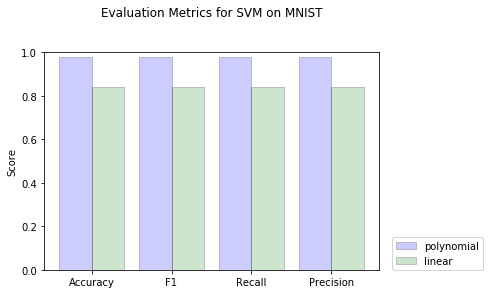

In [69]:
graph_scores(scores_SVM, titles_SVM, 'SVM on MNIST')

CPU times: user 2min 20s, sys: 188 ms, total: 2min 20s
Wall time: 2min 20s


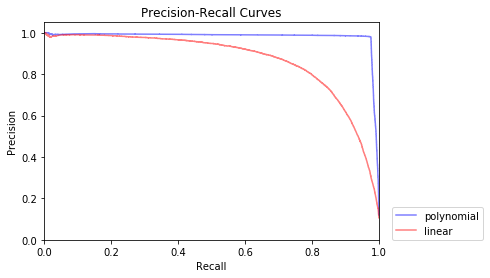

CPU times: user 744 ms, sys: 528 ms, total: 1.27 s
Wall time: 580 ms


In [67]:
%time confidence_SVM = [clf.decision_function(mnist_test.data) for clf in clf_SVM]
%time graph_precision_recall(mnist_test.target, confidence_SVM, titles_SVM)

## [k-Nearest Neighbors (kNN)](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) <a id='knn'></a>

This algorithm is not trained like the previous machine learning algorithms. Nearest Neighbors is an instance-based learning algorithm. This means is not trained to the data, each prediction is generated by finding the $k$ nearest neighbors [hart1968]. It works by calculating the distance from a query point to all other points in the training set, and the top k closest points are used to generate a prediction [cover-1967]. The class that belogs to the majority of the k neighbors is the class the query point is predicted to have, this is called majority voting [coomans1982]. 

To help improve the voting system in kNN it is possible to inversely weight the class label of each of the nearest neighbors based on their distance to the query point [samworth-2012]. The difference between weighted and unweighted kNN is small and decreases as the number of features increases, but for 15 or less features there has been shown to be at least a 5% improvement [samworth 2012].

Calculating the distance between the query and all of the training points can be very computationally demanding so an additional algorithm an be implemented to help calculate distance. The two most frequently used algorithms are kd-tree and BallTree. Both are considerably faster than calculating neighbors with brute force, and BallTree performs especially well in high dimensions. Note that tree implementations cannot be applied to sparse data. A kd-tree is a multidimensional binary search tree [bentley-1975]. In a kd-tree each node is a sample, and every level of the tree corresponds to a dimension. On each level the remaining samples are split based on their value in that dimension. This forms a binary search tree that allows nearest neighbor lokoup without calculating the distance for each sample [bentley-1975]. A ball tree is a complete binary tree that segments the data points into regions bounded by hyperspheres called balls [omohundro-1989]. Each ball corresponds to a node and is the smallest ball that can contain the balls corresponding to its children nodes [omohundro-1989]. The leaves of a balltree hold the information while the interior nodes are only used to guide the search [omohundro-1989].

Additionally the [distince metric](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) can be tailored to the dataset. Let $n$ be the number of dimensions in $\vec{x}$, and let $x_i$ represent the $i^{\text{th}}$ dimension of $\vec{x}$.

* Euclidean 
\begin{equation*}
dist(\vec{x}, \vec{y}) = \sum_{i=1}^n (x_i - y_i)^2
\end{equation*}
* Manhattan
\begin{equation*}
dist(\vec{x}, \vec{y}) = \sum_{i=1}^n \mid x_i - y_i \mid
\end{equation*}
* Chebyshev
\begin{equation*}
dist(\vec{x}, \vec{y}) = \max_{i \in [1, n]} ( \mid x_i - y_i \mid )
\end{equation*}
* Minkowski
\begin{equation*}
dist(\vec{x}, \vec{y}) = ( \sum_{i=1}^n \mid x_i - y_i \mid^p )^{1/p}
\end{equation*}

Notice Minowski distance is a generalized form of the other distance formulas. When $p = 1$ it is the same as Manhattan distance, when $p = \infty$ it is the same as Chebyshev distance, and when $p = 2$ it is the same as Euclidean distance. The value for $p$ can be any real number.

### k-Nearest Neighbors on RCV1 <a id='knn_rcv1'></a>

In [5]:
# This command changes the location of the temp storage for the notebook. Needed when running from docker.
%env JOBLIB_TEMP_FOLDER=/home/jovyan/work/tmp

env: JOBLIB_TEMP_FOLDER=/home/jovyan/work/tmp


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

clf_kNN = OneVsRestClassifier(KNeighborsClassifier(n_jobs=-1, algorithm='ball_tree'), n_jobs=-1)

# rcv1 training set does not contain all the labels and throws a warning.
# This with statement will suppress these warnings.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    %time clf_kNN.fit(np.array(rcv1_train.data.todense()), np.array(rcv1_train.target.todense()))

CPU times: user 28min 29s, sys: 1min 32s, total: 30min 1s
Wall time: 30min 52s


In [7]:
%time pred_kNN = clf_kNN.predict(np.array(rcv1_test.data[1203].todense()))

CPU times: user 2min 49s, sys: 34.4 s, total: 3min 23s
Wall time: 3min 27s


As you can see kNN is not feasible on RCV1 as the test set has 781265 samples and it took 3.5 minutes to generate a prediction on one. Because of this we can use dimensionality reduction. For this example we will use [truncated singular value decompisition (SVD)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Truncated SVD is intended to work on tf-idf matricies, and it works on sparce input. Because of this it is ideal for the RCV1 dataset. 

In [6]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100) 
svd.fit(rcv1_train.data)

%time train_data = svd.transform(rcv1_train.data)

CPU times: user 192 ms, sys: 16 ms, total: 208 ms
Wall time: 210 ms


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

clf_kNN = OneVsRestClassifier(KNeighborsClassifier(n_jobs=-1, algorithm='ball_tree'), n_jobs=-1)

# rcv1 training set does not contain all the labels and throws a warning.
# This with statement will suppress these warnings.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    %time clf_kNN.fit(train_data, rcv1_train.target)

CPU times: user 3.83 s, sys: 552 ms, total: 4.38 s
Wall time: 4.42 s


In [8]:
%time test_data = svd.transform(rcv1_test.data)
%time pred_kNN = clf_kNN.predict(test_data)

scores_kNN = get_scores(rcv1_test.target, pred_kNN, 'micro')

print_scores(scores_kNN, 'micro')

CPU times: user 6.33 s, sys: 408 ms, total: 6.74 s
Wall time: 6.74 s
CPU times: user 23d 10h 54min 56s, sys: 5min 17s, total: 23d 11h 13s
Wall time: 14h 20min 30s
Accuracy: 0.5014
micro-averaged F1: 0.7690
micro averaged recall: 0.6955
micro averaged precision: 0.8599


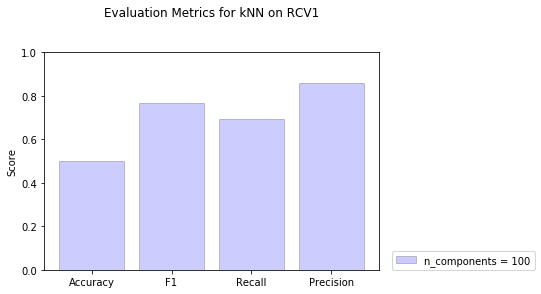

In [9]:
graph_scores([scores_kNN], ['n_components = 100'], 'kNN on RCV1')

### k-Nearest Neighbors on MNIST <a id='knn_mnist'></a>

In [27]:
from sklearn.neighbors import KNeighborsClassifier

clf_kNN = [KNeighborsClassifier(algorithm='ball_tree', p=1, n_jobs=-1),
           KNeighborsClassifier(algorithm='ball_tree', weights='distance', p=1, n_jobs=-1),
           KNeighborsClassifier(algorithm='ball_tree', weights='distance', p=2, n_jobs=-1),
           KNeighborsClassifier(algorithm='ball_tree', metric='chebyshev', n_jobs=-1)]

%time clf_kNN = [clf.fit(mnist_train.data, mnist_train.target) for clf in clf_kNN]

titles_kNN = ['Manhattan', 'Manhattan, Distance Weighted', 'Euclidean, Distance Weighted', 'Chebyshev']

CPU times: user 50.1 s, sys: 392 ms, total: 50.5 s
Wall time: 50.5 s


In [28]:
%time pred_kNN = [clf.predict(mnist_test.data) for clf in clf_kNN]

scores_kNN = [get_scores(mnist_test.target, pred, 'macro') for pred in pred_kNN]

for title, score in zip(titles_kNN, scores_kNN):
    print(f'\n{title}')
    print_scores(score, 'macro')

CPU times: user 2h 20min 36s, sys: 2.18 s, total: 2h 20min 39s
Wall time: 3min 47s

Manhattan
Accuracy: 0.9625
macro-averaged F1: 0.9624
macro averaged recall: 0.9619
macro averaged precision: 0.9636

Manhattan, Distance Weighted
Accuracy: 0.9638
macro-averaged F1: 0.9637
macro averaged recall: 0.9632
macro averaged precision: 0.9647

Euclidean, Distance Weighted
Accuracy: 0.9703
macro-averaged F1: 0.9702
macro averaged recall: 0.9699
macro averaged precision: 0.9707

Chebyshev
Accuracy: 0.8116
macro-averaged F1: 0.8078
macro averaged recall: 0.8074
macro averaged precision: 0.8161


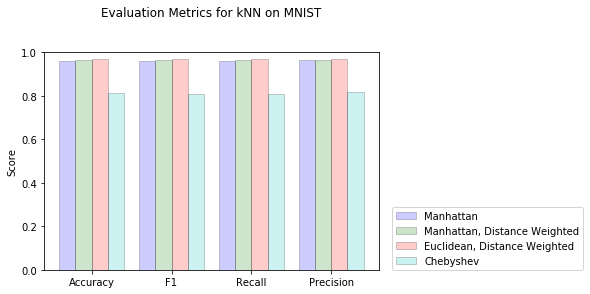

In [29]:
graph_scores(scores_kNN, titles_kNN, 'kNN on MNIST')

CPU times: user 2h 18min 32s, sys: 2.18 s, total: 2h 18min 34s
Wall time: 3min 37s


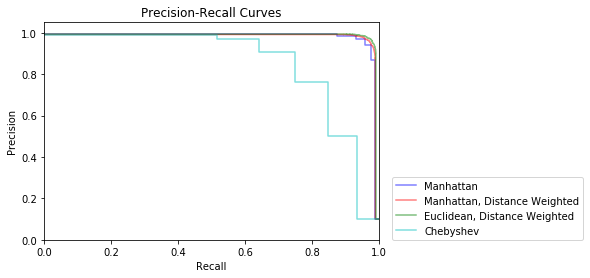

CPU times: user 520 ms, sys: 372 ms, total: 892 ms
Wall time: 435 ms


In [66]:
%time confidence_kNN = [clf.predict_proba(mnist_test.data) for clf in clf_kNN]
%time graph_precision_recall(mnist_test.target, confidence_kNN, titles_kNN)

## [Decision Trees](http://scikit-learn.org/stable/modules/tree.html) <a id='decision_trees'></a>

Decision Trees form a heirarchy of rules used to classify a document. Decision trees take the form of a tree, as the name suggests. Each node in the tree is a rule and each child node represents a possible outcome. A decision tree is traversed by starting at the root and moving to the appropriate child node based on the current node's rule. This makes decision trees easy to visualize and interpret. 

### Decision Trees on RCV1<a id='dt_rcv1'></a>

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

clf_DT = [OneVsRestClassifier(DecisionTreeClassifier(criterion='gini'), n_jobs=-1),
          OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy'), n_jobs=-1)]

# rcv1 training set does not contain all the labels and throws a warning.
# This with statement will suppress these warnings.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    %time clf_DT =  [clf.fit(rcv1_train.data, rcv1_train.target) for clf in clf_DT]

titles_DT = ['Gini Impurity', 'Entropy']

CPU times: user 9.48 s, sys: 1.16 s, total: 10.6 s
Wall time: 1min 37s


In [9]:
%time pred_DT = [clf.predict(rcv1_test.data) for clf in clf_DT]

scores_DT = [get_scores(rcv1_test.target, pred, 'micro') for pred in pred_DT]

for title, score in zip(titles_DT, scores_DT):
    print(f'\n{title}')
    print_scores(score, 'micro')

CPU times: user 1min 53s, sys: 33.5 s, total: 2min 27s
Wall time: 2min 27s

Gini Impurity
Accuracy: 0.2628
micro-averaged F1: 0.6818
micro averaged recall: 0.6741
micro averaged precision: 0.6897

Entropy
Accuracy: 0.2750
micro-averaged F1: 0.6811
micro averaged recall: 0.6701
micro averaged precision: 0.6925


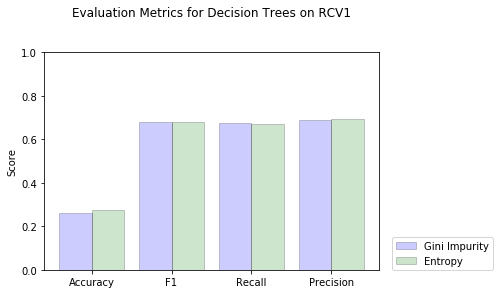

In [10]:
graph_scores(scores_DT, titles_DT, 'Decision Trees on RCV1')

CPU times: user 1min 52s, sys: 35.8 s, total: 2min 28s
Wall time: 2min 28s


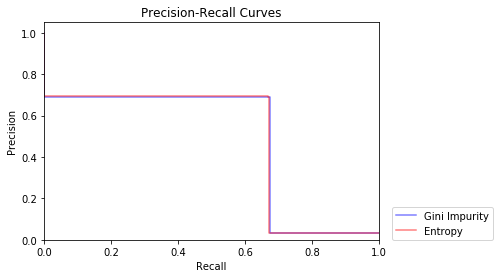

CPU times: user 37.8 s, sys: 7.21 s, total: 45 s
Wall time: 44.7 s


In [11]:
%time confidence_DT = [clf.predict_proba(rcv1_test.data) for clf in clf_DT]
%time graph_precision_recall(rcv1_test.target, confidence_DT, titles_DT)

### Decision Trees on MNIST <a id='dt_mnist'></a>

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

clf_DT = [DecisionTreeClassifier(criterion='gini'),
          DecisionTreeClassifier(criterion='entropy')]

%time clf_DT =  [clf.fit(mnist_train.data, mnist_train.target) for clf in clf_DT]

titles_DT = ['Gini Impurity', 'Entropy']

CPU times: user 11min 43s, sys: 188 ms, total: 11min 43s
Wall time: 39 s


In [38]:
%time pred_DT = [clf.predict(mnist_test.data) for clf in clf_DT]

scores_DT = [get_scores(mnist_test.target, pred, 'macro') for pred in pred_DT]

for title, score in zip(titles_DT, scores_DT):
    print(f'\n{title}')
    print_scores(score, 'macro')

CPU times: user 48 ms, sys: 44 ms, total: 92 ms
Wall time: 89.2 ms

Gini Impurity
Accuracy: 0.8686
macro-averaged F1: 0.8669
macro averaged recall: 0.8670
macro averaged precision: 0.8668

Entropy
Accuracy: 0.8756
macro-averaged F1: 0.8738
macro averaged recall: 0.8738
macro averaged precision: 0.8738


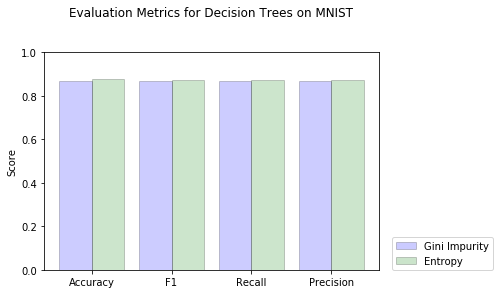

In [39]:
graph_scores(scores_DT, titles_DT, 'Decision Trees on MNIST')

CPU times: user 80 ms, sys: 60 ms, total: 140 ms
Wall time: 139 ms


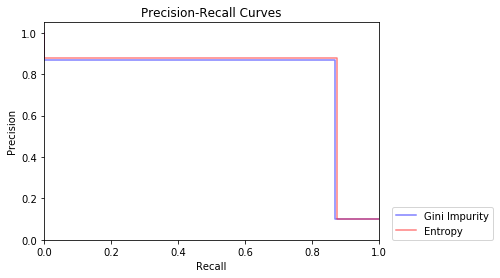

CPU times: user 500 ms, sys: 328 ms, total: 828 ms
Wall time: 361 ms


In [65]:
%time confidence_DT = [clf.predict_proba(mnist_test.data) for clf in clf_DT]
%time graph_precision_recall(mnist_test.target, confidence_DT, titles_DT)